In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
merged = sc.read_h5ad("data/co_integrated_data/mouse_neurons_counts_knafbouv+lit_ref.h5ad")

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\anndata\compat\__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [4]:
merged

AnnData object with n_obs × n_vars = 11138 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_counts.KNAF3_variance.standardized', 'vf_vst_counts.KNAF3_variable', 'vf_vst_co

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [6]:
np.unique(merged.obs['orig.ident'])

array([0, 1, 2, 3, 4], dtype=int32)

In [7]:
merged.obs['training_labels'].groupby(merged.obs['orig.ident']).value_counts()

orig.ident  training_labels
0           -1.0               1417
1           -1.0               2331
2            0.0               3265
3            1.0               1820
4           -1.0               2305
Name: count, dtype: int64

In [8]:
merged.obs['orig.ident'] = merged.obs['orig.ident'].apply(lambda x: 'BOUV5' if x == 0 else 'KATHE' if x == 1 else 'KNAF3' if x == 2 else 'KNAF4' if x == 3 else 'MATSON' if x == 4 else 'TREVISAN')

In [9]:
# # Mark unnassigned to -1, and knaf3-4 that are not labeled 1 to 0
# merged.obs['labels'] = -1
# merged.obs.loc[merged.obs['orig.ident'] == 'KNAF3-4_En1Sun1NeuN-GFP', 'labels'] = 0
# merged.obs.loc[merged.obs['GFP'] > 0, 'labels'] = 1

In [10]:
merged.obs['training_labels'].value_counts()

training_labels
-1.0    6053
 0.0    3265
 1.0    1820
Name: count, dtype: int64

In [11]:
# check which space it uses to plot the umap 
merged

AnnData object with n_obs × n_vars = 11138 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_counts.KNAF3_variance.standardized', 'vf_vst_counts.KNAF3_variable', 'vf_vst_co

In [12]:
merged.obs['training_labels'] = merged.obs['training_labels'].astype('category')

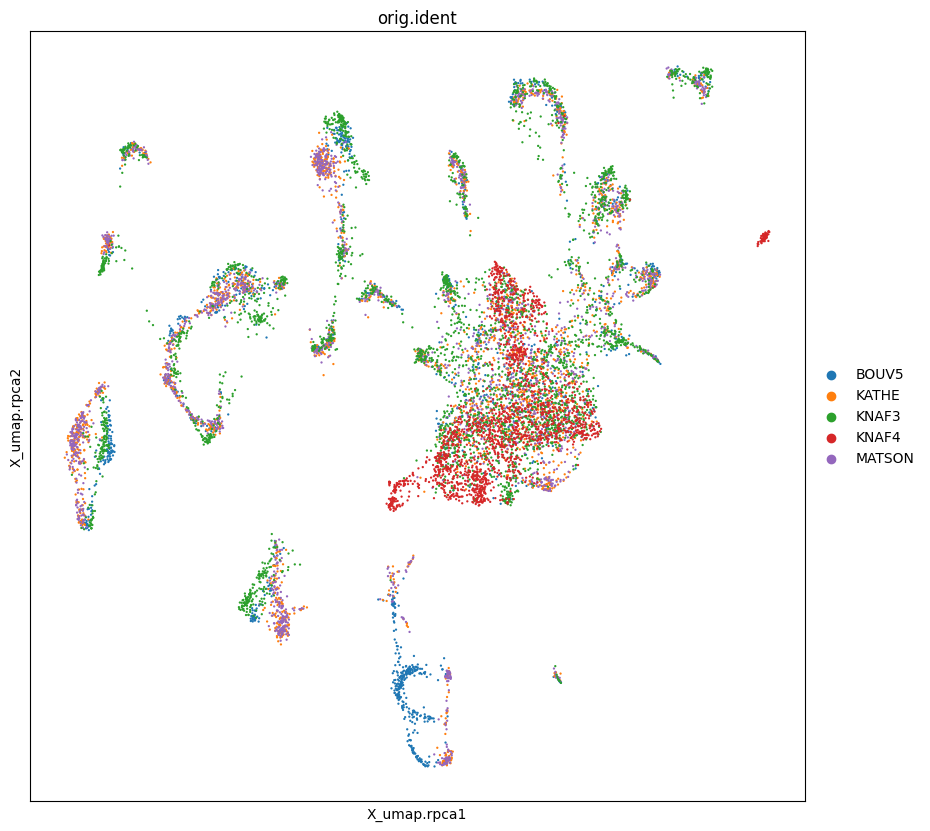

In [13]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, basis='X_umap.rpca', color='orig.ident', ax = ax)

In [14]:
merged.obs['annotation']  = merged.obs['training_labels'].apply(lambda x: 'CiteSeq+' if x == 1 else 'Citeseq-' if x == 0 else 'Unassigned')

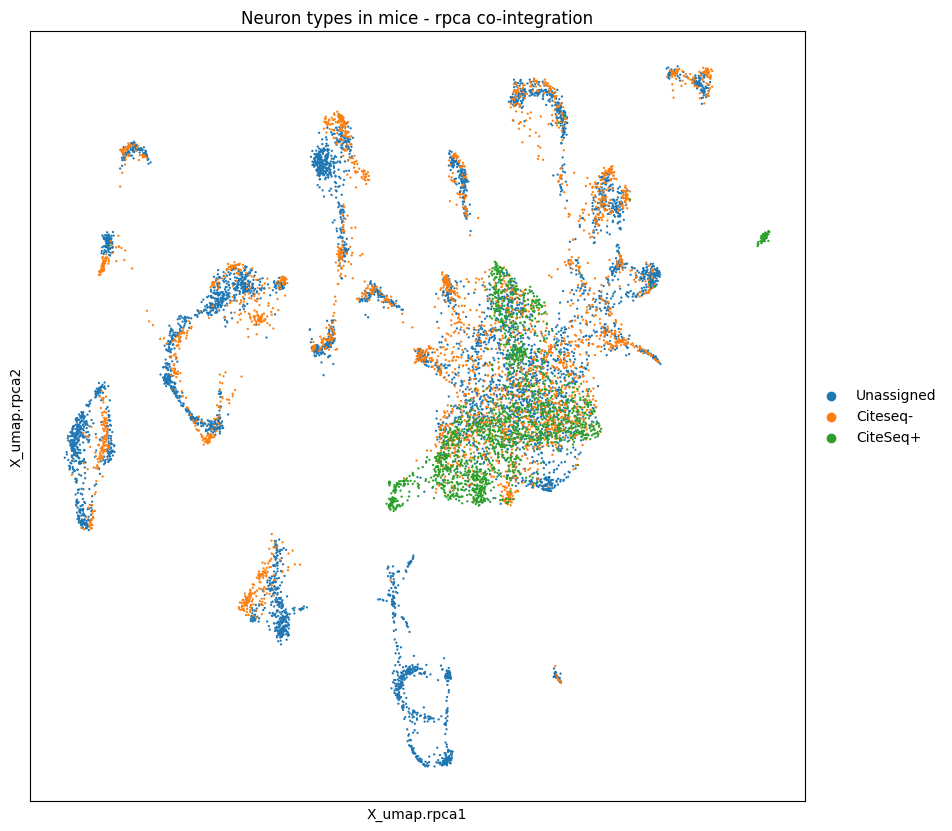

In [15]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, basis='X_umap.rpca', color='annotation', title='Neuron types in mice - rpca co-integration', ax = ax)

In [16]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_9396\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation
BOUV5       Unassigned    1417
            Citeseq-         0
            CiteSeq+         0
KATHE       Unassigned    2331
            Citeseq-         0
            CiteSeq+         0
KNAF3       Citeseq-      3265
            Unassigned       0
            CiteSeq+         0
KNAF4       CiteSeq+      1820
            Unassigned       0
            Citeseq-         0
MATSON      Unassigned    2305
            Citeseq-         0
            CiteSeq+         0
Name: count, dtype: int64

## Outlier detection in the knaf3-4 neurons

In [537]:
# Outlier detection model
# Isolation Forest
from sklearn.ensemble import IsolationForest

# Extract knaf4 neurons
knaf4 = merged[merged.obs['training_labels'] == 1]

# Detect outliers
clf = IsolationForest(contamination=0.05)

# Train model
clf.fit(knaf4.X)

# Predict outliers
outliers = clf.predict(knaf4.X)

In [538]:
# Count outliers
unique, counts = np.unique(outliers, return_counts=True)

print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(91), np.int64(1): np.int64(1729)}


C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\2320479696.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  knaf4.obs['outliers'] = outliers


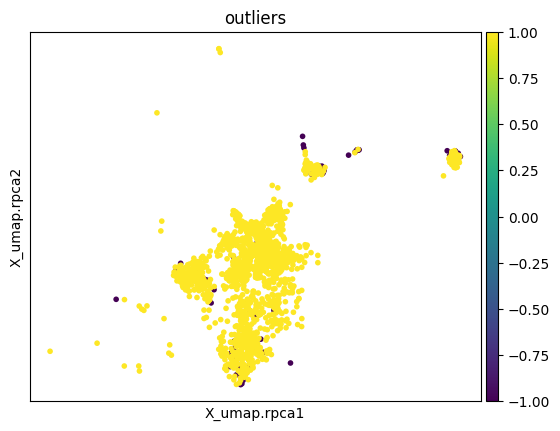

In [297]:
# Plot outliers in UMAP
knaf4.obs['outliers'] = outliers

sc.pl.embedding(knaf4, basis='X_umap.rpca', color='outliers')

No outliers

# Train classification model

## Use the original co-integration

In [625]:
# Split data into train, test and query
ref = merged[merged.obs['training_labels'] != -1]


In [626]:
ref.obs['training_labels'].value_counts()

training_labels
0.0    3265
1.0    1820
Name: count, dtype: int64

In [627]:
X = np.array(ref.obsm['X_rpca'])
y = ref.obs['training_labels']
n_classes = len(np.unique(y))

In [628]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [629]:
print("ref data shape: ", X.shape)
print("train data shape: ", X_train.shape)
print("test data shape: ", X_test.shape)
print("number of classes: ", n_classes)

ref data shape:  (5085, 50)
train data shape:  (4068, 50)
test data shape:  (1017, 50)
number of classes:  2


In [630]:
# Train xgboost
xgb = XGBClassifier()


In [631]:
# Grid search

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

In [632]:
# Predict using the best model
# xgb = grid_search.best_estimator_
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_xgb)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 92.53%
F1: 92.57%


In [633]:
# Train a SVM model
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)

# Predict
y_pred_svm = svm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_svm, average='weighted')
print("F1: %.2f" % f1)

Accuracy: 92.23%
F1: 0.92


In [635]:
# Predict on query data
X_query = np.array(merged.obsm['X_rpca'])
y_query_xgb = xgb.predict(X_query)
y_query_svm = svm.predict(X_query)

merged.obs['labels_xgb'] = y_query_xgb
merged.obs['labels_svm'] = y_query_svm

merged.obs['labels_xgb'] = merged.obs['labels_xgb'].astype('category')
merged.obs['labels_svm'] = merged.obs['labels_svm'].astype('category')

In [636]:
merged.obs['labels_xgb'].value_counts()

labels_xgb
0    8839
1    2299
Name: count, dtype: int64

In [637]:
merged.obs['labels_svm'].value_counts()

labels_svm
0.0    8854
1.0    2284
Name: count, dtype: int64

In [638]:
# COmpare predictions

print(accuracy_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))
print(f1_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))

0.9435266654695637
0.862753654811259


In [639]:
# Vount per orig
merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\549861126.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_xgb
BOUV5       0             1313
            1              104
KATHE       0             2153
            1              178
KNAF3       0             3217
            1               48
KNAF4       1             1792
            0               28
MATSON      0             2128
            1              177
Name: count, dtype: int64

In [640]:
# Vount per orig
merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\568467259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_svm
BOUV5       0.0           1341
            1.0             76
KATHE       0.0           2169
            1.0            162
KNAF3       0.0           3107
            1.0            158
KNAF4       1.0           1713
            0.0            107
MATSON      0.0           2130
            1.0            175
Name: count, dtype: int64

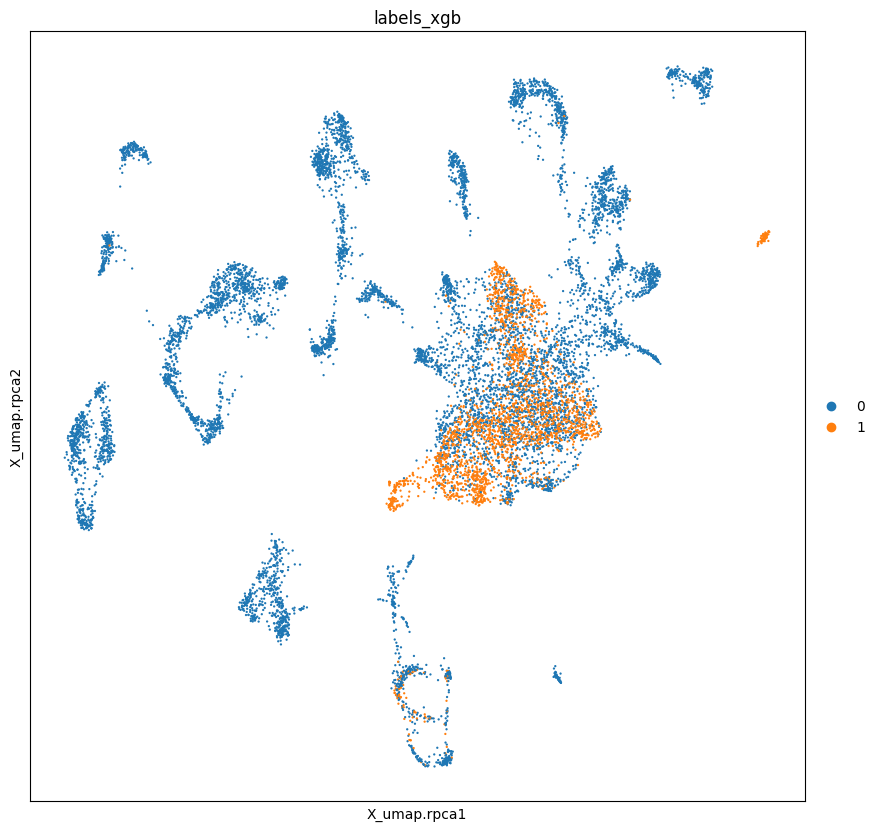

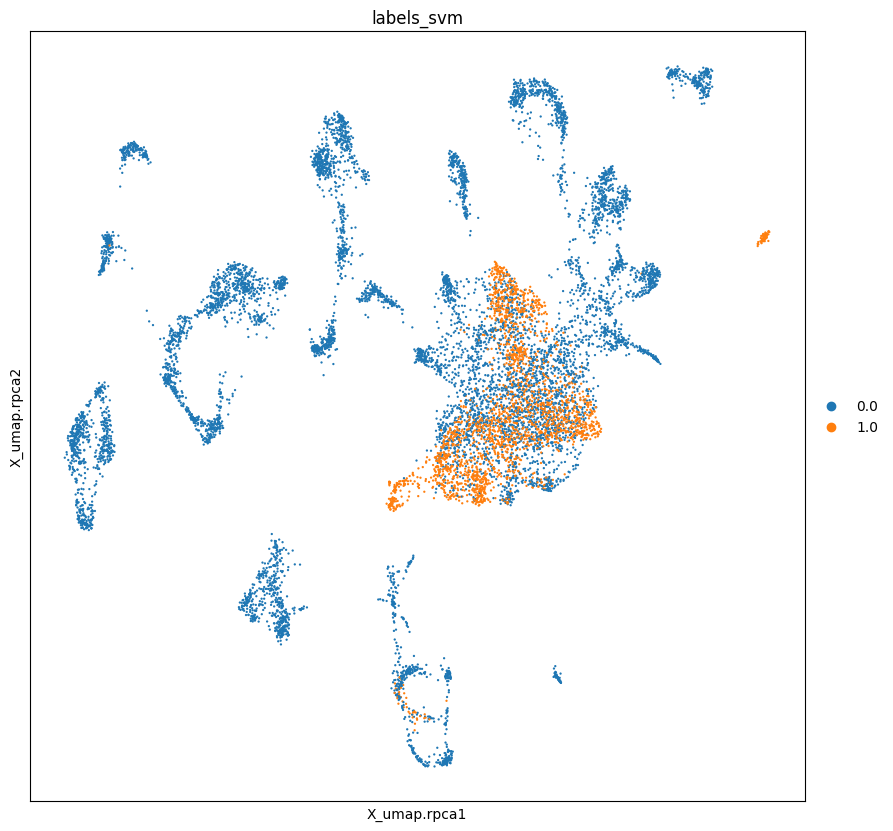

In [641]:
# Compare the results for each model
fig, ax = plt.subplots(1,1, figsize = (10,10))
# Plot umap with annotations using 4 colors for each annotation
# Change size of plot
sc.pl.embedding(merged, color='labels_xgb', basis='X_umap.rpca', ax = ax)

fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, color='labels_svm', basis='X_umap.rpca',ax=ax)

In [642]:
annotation = []
v1 = []

for l, r in zip(merged.obs['labels_xgb'], merged.obs['training_labels']):
    if l == 1 and r == 1:
        annotation.append('V1_CITEseq+')
        v1.append('V1')
    elif l == 1 and r == 0:
        annotation.append('CITEseq-')
        v1.append('Not_V1')
    elif l == 1 and r == -1:
        annotation.append('V1_predicted')
        v1.append('V1')
    elif l == 0 and r == -1:
        annotation.append('Not_V1_predicted')
        v1.append('Not_V1')
    elif l == 0 and r == 0:
        annotation.append('CITEseq-')
        v1.append('Not_V1')
    elif l == 0 and r == 1:
        annotation.append('V1_CITEseq+')
        v1.append('V1')


In [643]:
pd.DataFrame(annotation).value_counts()

0               
Not_V1_predicted    5594
CITEseq-            3265
V1_CITEseq+         1820
V1_predicted         459
Name: count, dtype: int64

In [644]:
merged.obs['annotation'] = annotation
merged.obs['v1'] = v1

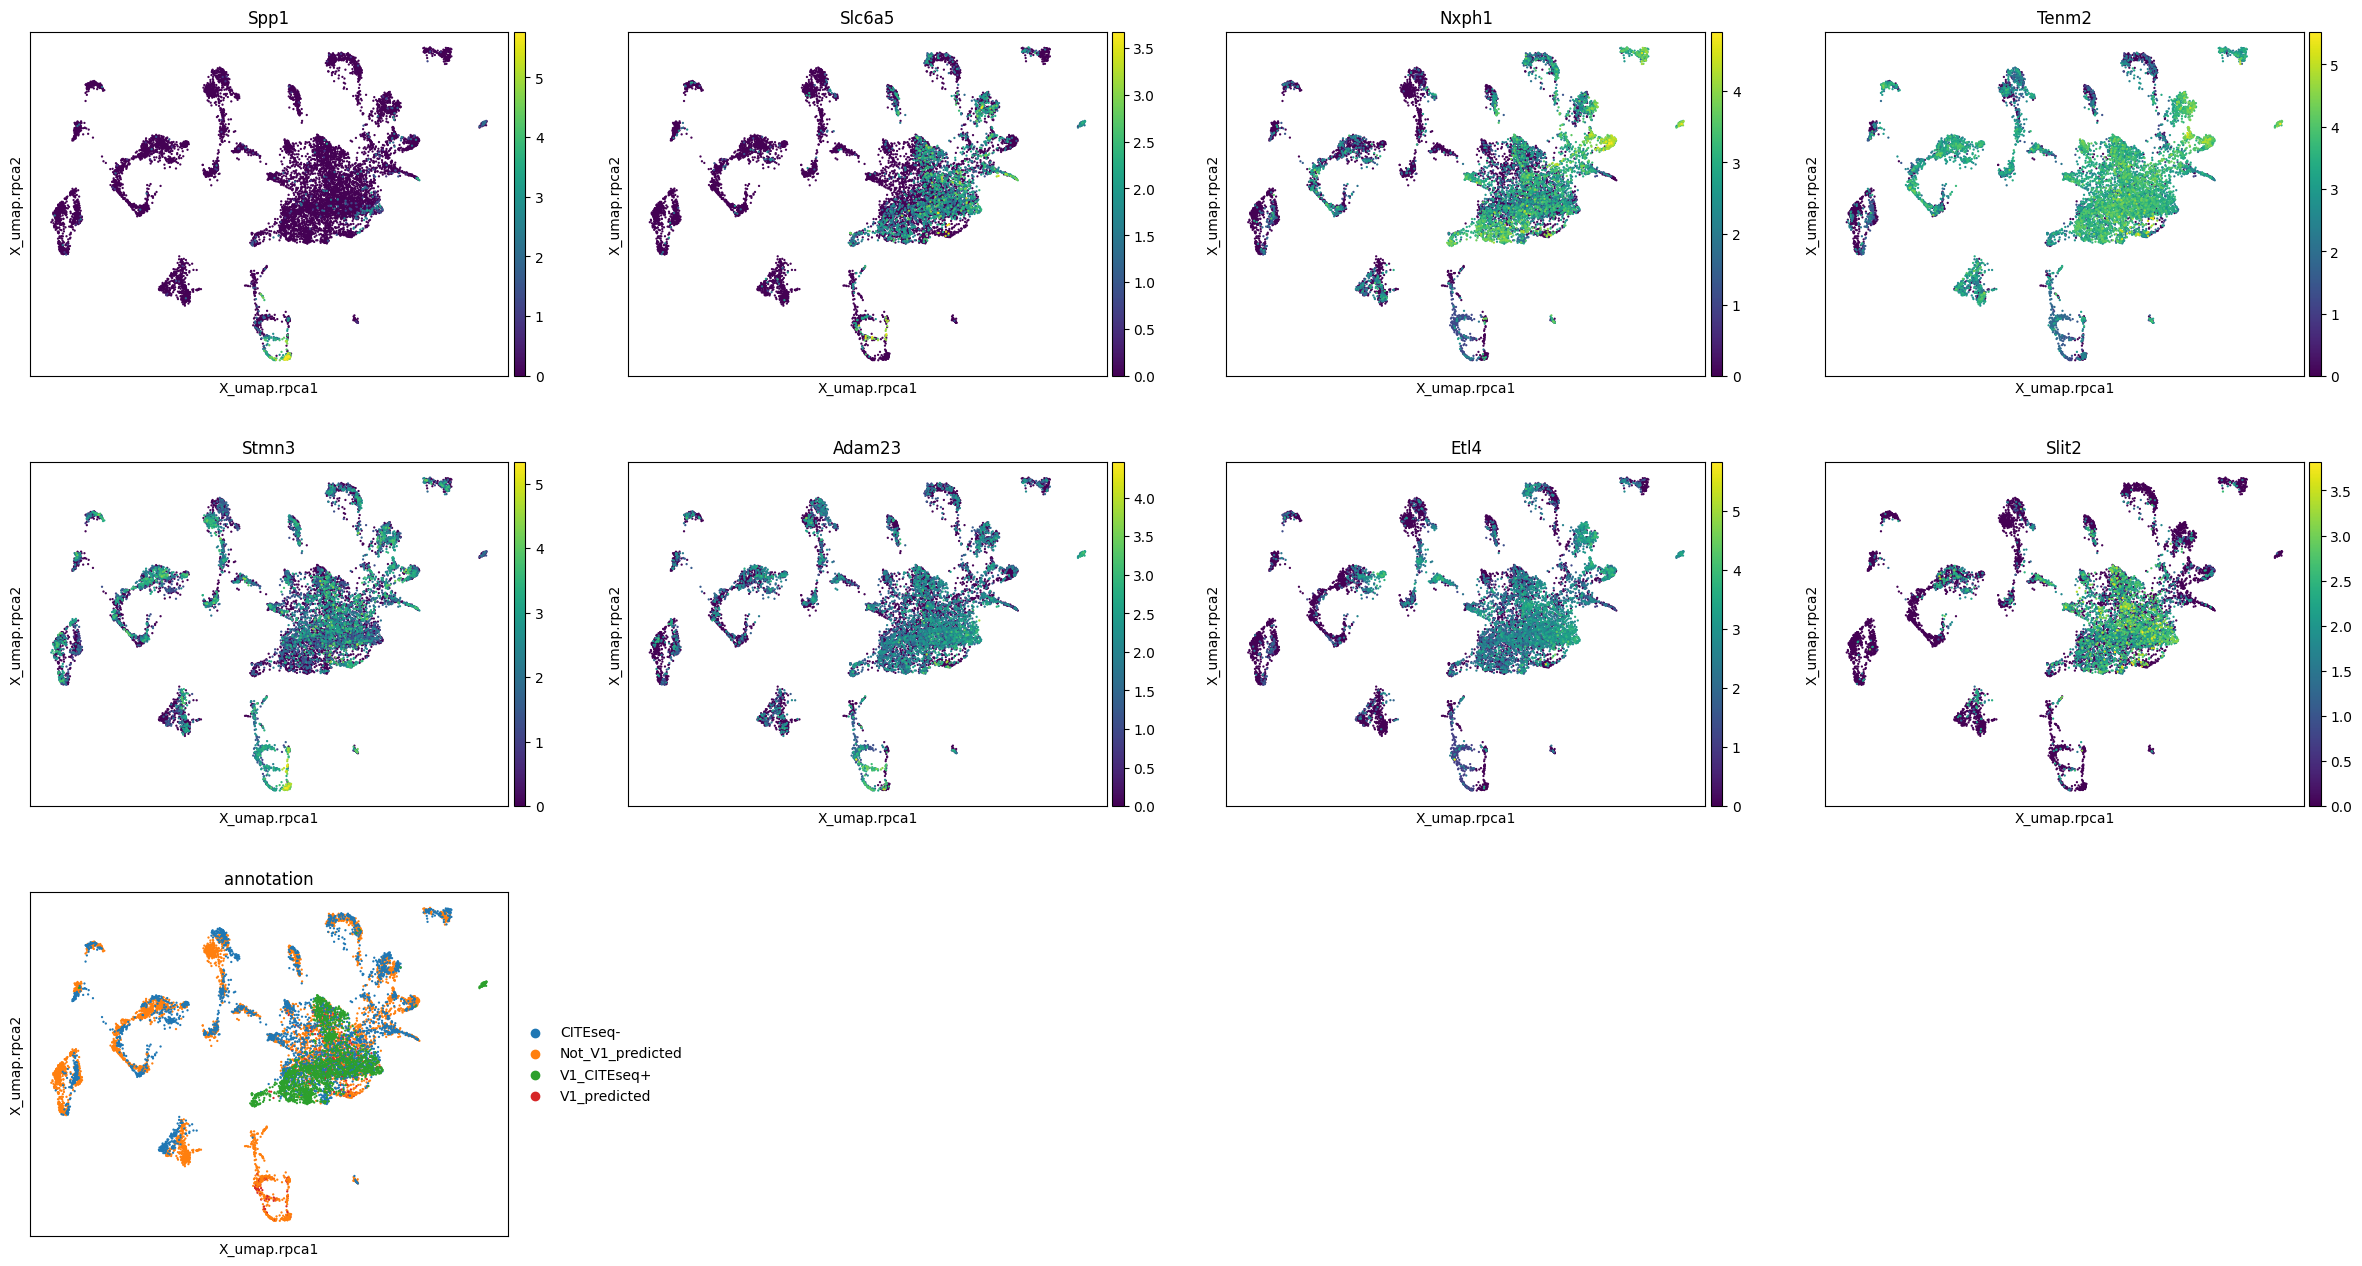

In [645]:
sc.pl.embedding(merged, color = ['Spp1', 'Slc6a5', 'Nxph1', 'Tenm2', 'Stmn3', 'Adam23', 'Etl4', 'Slit2', 'annotation'], basis='X_umap.rpca')

In [646]:
merged.uns['annotation_colors'] = ['yellow', 'orange', 'violet', 'green']

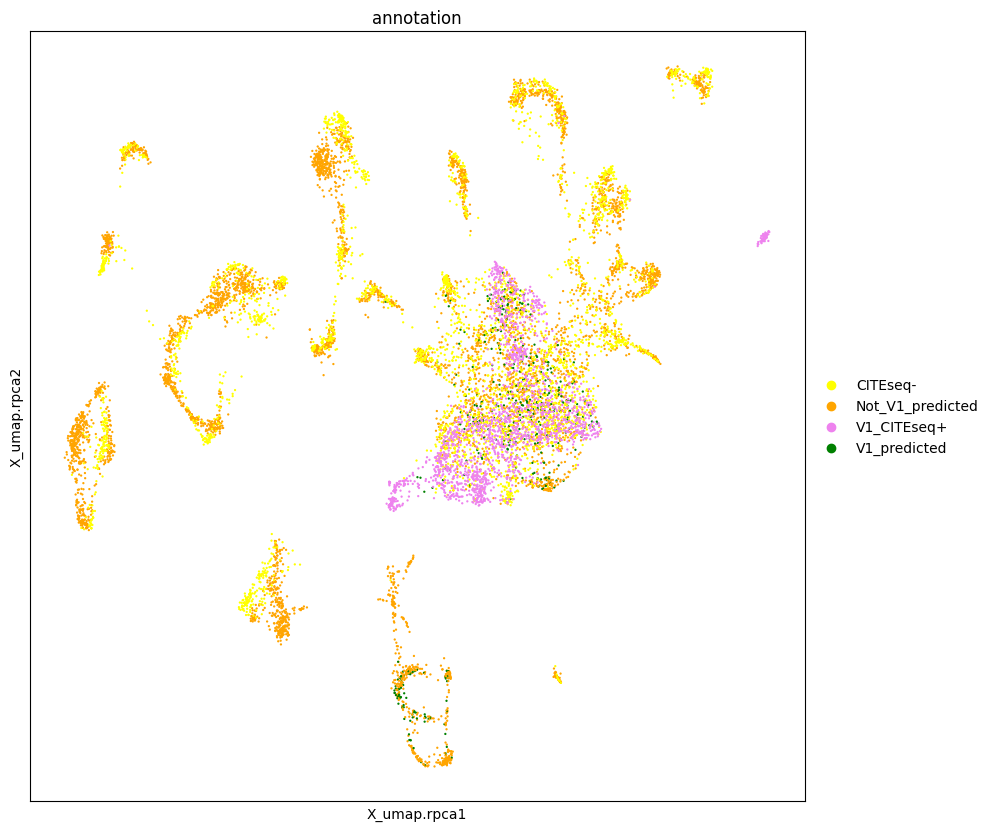

In [647]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, color='annotation', basis='X_umap.rpca', ax = ax)

In [648]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation      
BOUV5       Not_V1_predicted    1313
            V1_predicted         104
            CITEseq-               0
            V1_CITEseq+            0
KATHE       Not_V1_predicted    2153
            V1_predicted         178
            CITEseq-               0
            V1_CITEseq+            0
KNAF3       CITEseq-            3265
            Not_V1_predicted       0
            V1_CITEseq+            0
            V1_predicted           0
KNAF4       V1_CITEseq+         1820
            CITEseq-               0
            Not_V1_predicted       0
            V1_predicted           0
MATSON      Not_V1_predicted    2128
            V1_predicted         177
            CITEseq-               0
            V1_CITEseq+            0
Name: count, dtype: int64

In [649]:
merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\3651625991.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted
orig.ident,,,,
BOUV5,0,1313,0,104
KATHE,0,2153,0,178
KNAF3,3265,0,0,0
KNAF4,0,0,1820,0
MATSON,0,2128,0,177


In [650]:
counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\2427307299.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


In [651]:
counts_xgb

annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted
orig.ident,,,,
BOUV5,0,1313,0,104
KATHE,0,2153,0,178
KNAF3,3265,0,0,0
KNAF4,0,0,1820,0
MATSON,0,2128,0,177


In [652]:
def compute_props(counts):
    counts['V1_proportion'] = (counts['V1_predicted'] + counts['V1_CITEseq+']) / (counts['V1_predicted'] + counts['V1_CITEseq+'] + counts['CITEseq-'] + counts['Not_V1_predicted']) 
    return counts

In [653]:
compute_props(counts_xgb)

annotation,CITEseq-,Not_V1_predicted,V1_CITEseq+,V1_predicted,V1_proportion
orig.ident,,,,,
BOUV5,0,1313,0,104,0.073394
KATHE,0,2153,0,178,0.076362
KNAF3,3265,0,0,0,0.000000
KNAF4,0,0,1820,0,1.000000
MATSON,0,2128,0,177,0.076790


In [654]:
# Save the final merged data
merged.write('mouse_neurons_rpca_xgb+ref.h5ad')

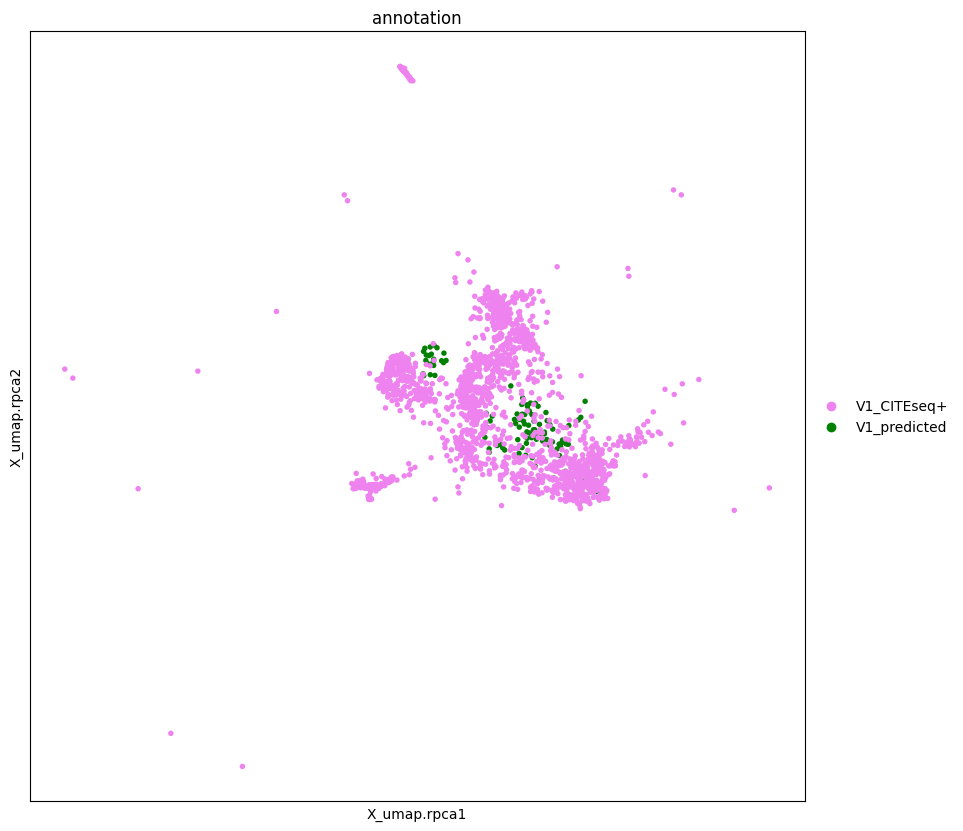

In [610]:
# plot the results
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged[merged.obs['v1'] == 'V1'], color='annotation', basis='X_umap.rpca', ax = ax)